## Some background reading

###### Space Weather:
- [Introduction](https://ccmc.gsfc.nasa.gov/RoR_WWW/SWREDI/2016/SpaceWeatherIntro_Bootcamp_2016.pdf)
- [Understanding space weather](https://www.sciencedirect.com/science/article/pii/S0273117715002252)

###### Particle Precipitation:
Here are a few particle precipitation resources that I believe are most valuable to start with:
- Technical details of the observations: [Redmon et al., [2017]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023339)
- Creating particle precipitation models from these data: [Hardy et al., [1987]](https://doi.org/10.1029/JA090iA05p04229) and [Newell et al., [2009]](https://doi.org/10.1029/2009JA014326)
- Considered the 'state of the art' model: [OVATION PRIME](https://ccmc.gsfc.nasa.gov/models/modelinfo.php?model=Ovation%20Prime)



## Imports and utility functions


In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from sklearn import *

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [2]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c)]#] | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)


In [3]:
df_cumulative.shape



(1947016, 150)

In [4]:
# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')



validation data shape = (55210, 150)
train data shape = (1838283, 150)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [5]:


%matplotlib inline  
import matplotlib.pyplot as plt



In [6]:
df_cumulative.shape
ovation_input = [df_val.index,df_val['SC_AACGM_LAT'],df_val['SC_AACGM_LTIME']]
# print(ovation_input[0])     
# print(min(df_cumulative['SC_AACGM_LAT']))
# plt.plot((df_cumulative['SC_AACGM_LAT']))

In [7]:
%matplotlib inline  

os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'

import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
import ipywidgets
from collections import OrderedDict
from functools import partial

auroral_types = ['diff','mono','wave','ions']
flux_types = [
                "energy",
                "number",
                "average energy"
            ]

f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
axS = f.add_subplot(122,projection='polar')
atype =auroral_types[0] #widgets['atype_select'].value
jtype = 'energy'#widgets['jtype_select'].value
bincorrect = True#widgets['bincorrect_toggle'].value
combine_hemispheres = True#widgets['combineNS_toggle'].value
manual_newell = -1#widgets['newell_float'].value

dt = ovation_input[0][0]#.date()#datetime.datetime(year,month,day,hour,minute)
print(dt)
dtstr = dt.strftime('%Y%m%d %H:%M')
# if jtype=='average energy':
#     estimator = AverageEnergyEstimator(atype)
#     get_precip_for_time = estimator.get_eavg_for_time
# else:
estimator = FluxEstimator(atype,jtype)
get_precip_for_time = estimator.get_flux_for_time

if manual_newell != -1.:
    estimator._dF = manual_newell
tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                'return_dF':True}
fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS
#print(mlatgridS)
#print(fluxgridN.shape)
if bincorrect:
    bcN = BinCorrector(mlatgridN,mltgridN)
    fluxgridN = bcN.fix(fluxgridN)
    bcS = BinCorrector(mlatgridS,mltgridS)
    fluxgridS = bcS.fix(fluxgridS)
    print("Correction Applied")
pcolor_kwargs = {'cmap':'gnuplot'}
manual_vmin = -1#wgts['vmin_float'].value
if manual_vmin != -1.:
    pcolor_kwargs['vmin']=manual_vmin
manual_vmax = -1#wgts['vmax_float'].value
if manual_vmax != -1.:
    pcolor_kwargs['vmax']=manual_vmax
mappableN = pcolor_flux(axN,mlatgridN,mltgridN,fluxgridN,'N',**pcolor_kwargs)
mappableS = pcolor_flux(axS,mlatgridS,mltgridS,fluxgridS,'S',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label=jtype)
f.colorbar(mappableS,ax=axS,label=jtype)
axN.set_title('Northern Hemisphere')
axS.set_title('Southern Hemisphere')
polar2dial(axN)
polar2dial(axS)
f.suptitle(('%s, %s' % (atype,jtype)
            +'\nNewell Coupling (%s): %f' % (dtstr,newell_coupling)))
plt.show()

#print(mlatgridN,mlatgridS)


# plt.figure(figsize=(20,20))
# #plt.scatter(X[:,3],Y)
# plt.plot(X[:1000,2])
# plt.plot(Y[:1000])

# #plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/geospacepy-0.1.0-py3.6.egg/geospacepy/__init__.py", line 8, in <module>
    from geospacepy.geospacepy_config import config
ModuleNotFoundError: No module named 'geospacepy.geospacepy_config'

Solar wind data files will be saved to /home/jackalak/.local/share/geospacepy
2010-01-01 00:19:00
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [8]:
from scipy import interpolate

from ovationpyme import ovation_utilities

from ovationpyme.ovation_utilities import robinson_auroral_conductance
from ovationpyme.ovation_utilities import brekke_moen_solar_conductance

import geospacepy
from geospacepy import special_datetime,astrodynamics2,satplottools
import aacgmv2 #available on pip

hemi='N' #????????????????
return_dF=False
combine_hemispheres=True

doy = dt.timetuple().tm_yday


if hemi=='N':
    weights = estimator.season_weights(doy)

dF = ovation_utilities.calc_dF(dt)

season_fluxes_outs = estimator.get_season_fluxes(dF)
grid_mlats,grid_mlts,seasonfluxesN,seasonfluxesS = season_fluxes_outs

gridflux = np.zeros_like(seasonfluxesN['summer'])
for season,W in weights.items():
    gridfluxN,gridfluxS = seasonfluxesN[season],seasonfluxesS[season]
    if combine_hemispheres:
        gridflux += W*(gridfluxN+gridfluxS)/2


# print( grid_mlats,grid_mlts,gridflux)
#print( grid_mlats[:,0])
#print( grid_mlts[0,:])
# print(estimator.seasonal_flux_estimators)
# print(estimator.seasonal_flux_estimators)

In [9]:
40/.50632911

79.00000061225

In [10]:
%matplotlib inline  

os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'

import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
from scipy import interpolate
from ovationpyme import ovation_utilities
from ovationpyme.ovation_utilities import robinson_auroral_conductance
from ovationpyme.ovation_utilities import brekke_moen_solar_conductance
import geospacepy
from geospacepy import special_datetime,astrodynamics2,satplottools
import aacgmv2 #available on pip


import ipywidgets
from collections import OrderedDict
from functools import partial

auroral_types = ['diff','mono','wave']#,'ions']
flux_types = [
                "energy",
                "number",
                "average energy"
            ]



jtype = 'energy'#widgets['jtype_select'].value
bincorrect = True#widgets['bincorrect_toggle'].value
combine_hemispheres = True#widgets['combineNS_toggle'].value
hemi='N' #????????????????
return_dF=False
combine_hemispheres=True



ovation_input = [df_val.index,df_val['SC_AACGM_LAT'],df_val['SC_AACGM_LTIME']]

times = ovation_input[0]
lats = ovation_input[1]
longs = ovation_input[2]

ovation_fluxes = np.zeros((4,len(ovation_input[0])))

# last_ovation_15_min_index = 0
# ovation_15_min_index = 1

for atype_index in range(len(auroral_types)):
    dt = times[-1]
    sw = ovation_utilities.read_solarwind(dt)
    
    atype =auroral_types[atype_index] #widgets['atype_select'].value  
    estimator = FluxEstimator(atype,jtype)

    for i in range(0,len(times)):
        
        dt = times[i]
        lat = lats[i]
        long = longs[i]
        
        if lat >= 50.:
            
            lat_index = int(round((lat - 50.)/.50632911))
            long_index = int(round(long/ 0.25263158))     

            sw_last = sw.copy()
            sw = ovation_utilities.read_solarwind(dt)
            if sw['jd'][0] != sw_last['jd'][0]: 
                print(sw['jd'][0], dt)             
                print('sw != sw_last ', i, dt)

                doy = dt.timetuple().tm_yday
                weights = estimator.season_weights(doy)
                dF = ovation_utilities.calc_dF(dt)

                season_fluxes_outs = estimator.get_season_fluxes(dF)
                grid_mlats,grid_mlts,seasonfluxesN,seasonfluxesS = season_fluxes_outs

                gridflux = np.zeros_like(seasonfluxesN['summer'])
                for season,W in weights.items():
                    gridfluxN,gridfluxS = seasonfluxesN[season],seasonfluxesS[season]
                    if combine_hemispheres:
                        gridflux += W*(gridfluxN+gridfluxS)/2


                if bincorrect:
                    bcN = BinCorrector(grid_mlats,grid_mlts)
                    gridflux = bcN.fix(gridflux)

                ovation_fluxes[atype_index,i] = gridflux[lat_index, long_index]
            else:
                #Uses last gridflux calc
                #print('sw == sw_last ', i, dt)
                ovation_fluxes[atype_index,i] = gridflux[lat_index, long_index]
            
            #print(i, ovation_fluxes[i], dt, lat,long,lat_index, long_index)

        else:
            #print(i, lat, long)
            ovation_fluxes[atype_index,i] =0

        

2455196.0416666665 2010-01-01 00:20:00
sw != sw_last  1 2010-01-01 00:20:00
2455197.5 2010-01-02 11:35:00
sw != sw_last  280 2010-01-02 11:35:00
2455199.125 2010-01-04 02:15:00
sw != sw_last  535 2010-01-04 02:15:00
2455200.5833333335 2010-01-05 13:15:00
sw != sw_last  905 2010-01-05 13:15:00
2455202.0833333335 2010-01-07 01:45:00
sw != sw_last  1115 2010-01-07 01:45:00
2455203.5833333335 2010-01-08 13:40:00
sw != sw_last  1261 2010-01-08 13:40:00
2455205.0833333335 2010-01-10 01:55:00
sw != sw_last  1737 2010-01-10 01:55:00
2455206.5833333335 2010-01-11 13:45:00
sw != sw_last  1902 2010-01-11 13:45:00
2455208.125 2010-01-13 02:02:00
sw != sw_last  2034 2010-01-13 02:02:00
2455209.9166666665 2010-01-14 21:30:00
sw != sw_last  2495 2010-01-14 21:30:00
2455211.375 2010-01-16 08:30:00
sw != sw_last  2780 2010-01-16 08:30:00
2455213.125 2010-01-18 02:10:00
sw != sw_last  3056 2010-01-18 02:10:00
2455214.7916666665 2010-01-19 18:41:00
sw != sw_last  3269 2010-01-19 18:41:00
2455216.29166666

2455382.0 2010-07-05 23:17:00
sw != sw_last  31148 2010-07-05 23:17:00
2455383.4583333335 2010-07-07 10:18:00
sw != sw_last  31259 2010-07-07 10:18:00
2455385.0416666665 2010-07-09 00:05:00
sw != sw_last  31404 2010-07-09 00:05:00
2455386.5 2010-07-10 11:05:00
sw != sw_last  31818 2010-07-10 11:05:00
2455388.5833333335 2010-07-12 13:09:00
sw != sw_last  32080 2010-07-12 13:09:00
2455390.0416666665 2010-07-14 00:15:00
sw != sw_last  32110 2010-07-14 00:15:00
2455391.5416666665 2010-07-15 12:31:00
sw != sw_last  32213 2010-07-15 12:31:00
2455393.0 2010-07-16 23:31:00
sw != sw_last  32460 2010-07-16 23:31:00
2455395.2916666665 2010-07-19 06:31:00
sw != sw_last  32541 2010-07-19 06:31:00
2455399.2083333335 2010-07-23 04:01:00
sw != sw_last  32573 2010-07-23 04:01:00
2455400.8333333335 2010-07-24 19:54:00
sw != sw_last  33067 2010-07-24 19:54:00
2455402.2916666665 2010-07-26 06:54:00
sw != sw_last  33278 2010-07-26 06:54:00
2455405.0416666665 2010-07-29 00:12:00
sw != sw_last  33448 2010-07

2455208.125 2010-01-13 02:02:00
sw != sw_last  2034 2010-01-13 02:02:00
2455209.9166666665 2010-01-14 21:30:00
sw != sw_last  2495 2010-01-14 21:30:00
2455211.375 2010-01-16 08:30:00
sw != sw_last  2780 2010-01-16 08:30:00
2455213.125 2010-01-18 02:10:00
sw != sw_last  3056 2010-01-18 02:10:00
2455214.7916666665 2010-01-19 18:41:00
sw != sw_last  3269 2010-01-19 18:41:00
2455216.2916666665 2010-01-21 06:21:00
sw != sw_last  3451 2010-01-21 06:21:00
2455217.75 2010-01-22 17:21:00
sw != sw_last  3938 2010-01-22 17:21:00
2455219.4166666665 2010-01-24 09:07:00
sw != sw_last  4231 2010-01-24 09:07:00
2455220.875 2010-01-25 20:15:00
sw != sw_last  4296 2010-01-25 20:15:00
2455222.4166666665 2010-01-27 09:38:00
sw != sw_last  4571 2010-01-27 09:38:00
2455223.875 2010-01-28 20:56:00
sw != sw_last  5158 2010-01-28 20:56:00
2455225.3333333335 2010-01-30 07:56:00
sw != sw_last  5395 2010-01-30 07:56:00
2455226.8333333335 2010-01-31 19:31:00
sw != sw_last  5827 2010-01-31 19:31:00
2455228.375 2010

2455395.2916666665 2010-07-19 06:31:00
sw != sw_last  32541 2010-07-19 06:31:00
2455399.2083333335 2010-07-23 04:01:00
sw != sw_last  32573 2010-07-23 04:01:00
2455400.8333333335 2010-07-24 19:54:00
sw != sw_last  33067 2010-07-24 19:54:00
2455402.2916666665 2010-07-26 06:54:00
sw != sw_last  33278 2010-07-26 06:54:00
2455405.0416666665 2010-07-29 00:12:00
sw != sw_last  33448 2010-07-29 00:12:00
2455406.5 2010-07-30 11:16:00
sw != sw_last  33588 2010-07-30 11:16:00
2455407.9583333335 2010-07-31 22:35:00
sw != sw_last  33760 2010-07-31 22:35:00
2455409.4166666665 2010-08-02 09:35:00
sw != sw_last  34394 2010-08-02 09:35:00
2455413.125 2010-08-06 02:45:00
sw != sw_last  34583 2010-08-06 02:45:00
2455414.6666666665 2010-08-07 15:20:00
sw != sw_last  35010 2010-08-07 15:20:00
2455416.125 2010-08-09 02:22:00
sw != sw_last  35322 2010-08-09 02:22:00
2455417.5833333335 2010-08-10 13:46:00
sw != sw_last  35587 2010-08-10 13:46:00
2455419.2083333335 2010-08-12 04:47:00
sw != sw_last  36056 201

2455220.875 2010-01-25 20:15:00
sw != sw_last  4296 2010-01-25 20:15:00
2455222.4166666665 2010-01-27 09:38:00
sw != sw_last  4571 2010-01-27 09:38:00
2455223.875 2010-01-28 20:56:00
sw != sw_last  5158 2010-01-28 20:56:00
2455225.3333333335 2010-01-30 07:56:00
sw != sw_last  5395 2010-01-30 07:56:00
2455226.8333333335 2010-01-31 19:31:00
sw != sw_last  5827 2010-01-31 19:31:00
2455228.375 2010-02-02 08:05:00
sw != sw_last  6169 2010-02-02 08:05:00
2455229.875 2010-02-03 20:45:00
sw != sw_last  6430 2010-02-03 20:45:00
2455231.3333333335 2010-02-05 07:45:00
sw != sw_last  6791 2010-02-05 07:45:00
2455232.8333333335 2010-02-06 19:03:00
sw != sw_last  7055 2010-02-06 19:03:00
2455234.2916666665 2010-02-08 06:03:00
sw != sw_last  7441 2010-02-08 06:03:00
2455236.125 2010-02-10 02:03:00
sw != sw_last  7589 2010-02-10 02:03:00
2455238.0416666665 2010-02-12 00:45:00
sw != sw_last  7984 2010-02-12 00:45:00
2455239.625 2010-02-13 14:14:00
sw != sw_last  8492 2010-02-13 14:14:00
2455241.2916666

2455413.125 2010-08-06 02:45:00
sw != sw_last  34583 2010-08-06 02:45:00
2455414.6666666665 2010-08-07 15:20:00
sw != sw_last  35010 2010-08-07 15:20:00
2455416.125 2010-08-09 02:22:00
sw != sw_last  35322 2010-08-09 02:22:00
2455417.5833333335 2010-08-10 13:46:00
sw != sw_last  35587 2010-08-10 13:46:00
2455419.2083333335 2010-08-12 04:47:00
sw != sw_last  36056 2010-08-12 04:47:00
2455421.125 2010-08-14 02:10:00
sw != sw_last  36217 2010-08-14 02:10:00
2455422.5833333335 2010-08-15 13:50:00
sw != sw_last  36800 2010-08-15 13:50:00
2455425.0416666665 2010-08-18 00:05:00
sw != sw_last  37349 2010-08-18 00:05:00
2455427.0 2010-08-20 00:00:00
sw != sw_last  37657 2010-08-20 00:00:00
2455428.5 2010-08-21 11:30:00
sw != sw_last  38042 2010-08-21 11:30:00
2455430.0 2010-08-23 00:00:00
sw != sw_last  38136 2010-08-23 00:00:00
2455431.5833333335 2010-08-24 13:19:00
sw != sw_last  38333 2010-08-24 13:19:00
2455434.0 2010-08-27 00:00:00
sw != sw_last  38462 2010-08-27 00:00:00
2455435.541666666

In [11]:
    
ovation_input = [df_train.index,df_train['SC_AACGM_LAT'],df_train['SC_AACGM_LTIME']]


times = ovation_input[0]
lats = ovation_input[1]
longs = ovation_input[2]

ovation_fluxes_train = np.zeros((4,len(ovation_input[0])))

# last_ovation_15_min_index = 0
# ovation_15_min_index = 1

for atype_index in range(len(auroral_types)):
    dt = times[-1]
    sw = ovation_utilities.read_solarwind(dt)
    
    atype =auroral_types[atype_index] #widgets['atype_select'].value  
    estimator = FluxEstimator(atype,jtype)

    for i in range(0,len(times)):
        
        dt = times[i]
        lat = lats[i]
        long = longs[i]
        
        if lat >= 50.:
            
            lat_index = int(round((lat - 50.)/.50632911))
            long_index = int(round(long/ 0.25263158))     

            sw_last = sw.copy()
            sw = ovation_utilities.read_solarwind(dt)
            if sw['jd'][0] != sw_last['jd'][0]: 
                print(sw['jd'][0], dt)             
                print('sw != sw_last ', i, dt)

                doy = dt.timetuple().tm_yday
                weights = estimator.season_weights(doy)
                dF = ovation_utilities.calc_dF(dt)

                season_fluxes_outs = estimator.get_season_fluxes(dF)
                grid_mlats,grid_mlts,seasonfluxesN,seasonfluxesS = season_fluxes_outs

                gridflux = np.zeros_like(seasonfluxesN['summer'])
                for season,W in weights.items():
                    gridfluxN,gridfluxS = seasonfluxesN[season],seasonfluxesS[season]
                    if combine_hemispheres:
                        gridflux += W*(gridfluxN+gridfluxS)/2


                if bincorrect:
                    bcN = BinCorrector(grid_mlats,grid_mlts)
                    gridflux = bcN.fix(gridflux)

                ovation_fluxes_train[atype_index,i] = gridflux[lat_index, long_index]
            else:
                #Uses last gridflux calc
                #print('sw == sw_last ', i, dt)
                ovation_fluxes_train[atype_index,i] = gridflux[lat_index, long_index]
            
            #print(i, ovation_fluxes[i], dt, lat,long,lat_index, long_index)

        else:
            #print(i, lat, long)
            ovation_fluxes_train[atype_index,i] =0
            
print(times, ovation_fluxes_train,times.shape, ovation_fluxes_train.shape)
#print(min(ovation_fluxes[atype_index,i]),max(ovation_fluxes[atype_index,i]))

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_utilities.py:83: RuntimeWarning: invalid value encountered in less
  neg_tc = BT*np.cos(tc)*Bz < 0


2446822.8333333335 1987-01-28 19:09:00
sw != sw_last  7 1987-01-28 19:09:00
2446885.7916666665 1987-04-01 18:42:00
sw != sw_last  13 1987-04-01 18:42:00
2446908.7916666665 1987-04-24 18:56:00
sw != sw_last  73 1987-04-24 18:56:00
2446913.875 1987-04-29 20:35:00
sw != sw_last  113 1987-04-29 20:35:00
2446945.625 1987-05-31 14:07:00
sw != sw_last  135 1987-05-31 14:07:00
2446947.1666666665 1987-06-02 03:19:00
sw != sw_last  186 1987-06-02 03:19:00
2446948.6666666665 1987-06-03 15:45:00
sw != sw_last  281 1987-06-03 15:45:00
2446956.6666666665 1987-06-11 15:12:00
sw != sw_last  286 1987-06-11 15:12:00
2446961.9166666665 1987-06-16 21:55:00
sw != sw_last  299 1987-06-16 21:55:00
2446970.8333333335 1987-06-25 19:44:00
sw != sw_last  357 1987-06-25 19:44:00
2446985.125 1987-07-10 02:40:00
sw != sw_last  368 1987-07-10 02:40:00
2446989.0833333335 1987-07-14 01:15:00
sw != sw_last  370 1987-07-14 01:15:00
2446995.75 1987-07-20 17:21:00
sw != sw_last  378 1987-07-20 17:21:00
2446885.7916666665 

2452094.5416666665 2001-07-05 12:43:00
sw != sw_last  13145 2001-07-05 12:43:00
2452096.0833333335 2001-07-07 01:57:00
sw != sw_last  13438 2001-07-07 01:57:00
2452097.5416666665 2001-07-08 12:57:00
sw != sw_last  13749 2001-07-08 12:57:00
2452099.0 2001-07-09 23:57:00
sw != sw_last  13865 2001-07-09 23:57:00
2452100.5 2001-07-11 11:23:00
sw != sw_last  14199 2001-07-11 11:23:00
2452101.9583333335 2001-07-12 22:57:00
sw != sw_last  14734 2001-07-12 22:57:00
2452105.0416666665 2001-07-16 00:01:00
sw != sw_last  14752 2001-07-16 00:01:00
2452107.0416666665 2001-07-18 00:35:00
sw != sw_last  14835 2001-07-18 00:35:00
2452109.0416666665 2001-07-20 00:02:00
sw != sw_last  15034 2001-07-20 00:02:00
2452110.5 2001-07-21 11:08:00
sw != sw_last  15526 2001-07-21 11:08:00
2452120.0416666665 2001-07-31 00:20:00
sw != sw_last  15685 2001-07-31 00:20:00
2452122.0416666665 2001-08-02 00:42:00
sw != sw_last  15704 2001-08-02 00:42:00
2452126.0416666665 2001-08-06 00:23:00
sw != sw_last  15927 2001-08

2452222.0416666665 2001-11-10 00:01:00
sw != sw_last  57397 2001-11-10 00:01:00
2452223.5 2001-11-11 11:31:00
sw != sw_last  57667 2001-11-11 11:31:00
2452225.4583333335 2001-11-13 10:16:00
sw != sw_last  58321 2001-11-13 10:16:00
2452227.0416666665 2001-11-15 00:21:00
sw != sw_last  58643 2001-11-15 00:21:00
2452228.5 2001-11-16 11:40:00
sw != sw_last  59089 2001-11-16 11:40:00
2452230.0416666665 2001-11-18 00:32:00
sw != sw_last  59469 2001-11-18 00:32:00
2452231.5 2001-11-19 11:35:00
sw != sw_last  59720 2001-11-19 11:35:00
2452233.2083333335 2001-11-21 04:10:00
sw != sw_last  59973 2001-11-21 04:10:00
2452234.7083333335 2001-11-22 16:39:00
sw != sw_last  60404 2001-11-22 16:39:00
2452236.1666666665 2001-11-24 03:39:00
sw != sw_last  60812 2001-11-24 03:39:00
2452237.625 2001-11-25 14:39:00
sw != sw_last  61331 2001-11-25 14:39:00
2452239.2083333335 2001-11-27 04:31:00
sw != sw_last  62058 2001-11-27 04:31:00
2452242.0416666665 2001-11-30 00:23:00
sw != sw_last  62430 2001-11-30 00:

2452262.0833333335 2001-12-20 01:15:00
sw != sw_last  98618 2001-12-20 01:15:00
2452263.5416666665 2001-12-21 12:15:00
sw != sw_last  99397 2001-12-21 12:15:00
2452269.0416666665 2001-12-27 00:31:00
sw != sw_last  99467 2001-12-27 00:31:00
2452271.0416666665 2001-12-29 00:03:00
sw != sw_last  99681 2001-12-29 00:03:00
https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2002/omni2_h0_mrg1hr_20020101_v01.cdf
2452272.5 2001-12-30 11:03:00
sw != sw_last  100061 2001-12-30 11:03:00
2451909.2916666665 2001-01-01 06:57:00
sw != sw_last  100209 2001-01-01 06:57:00
2451972.4166666665 2001-03-05 09:10:00
sw != sw_last  100312 2001-03-05 09:10:00
2452099.0416666665 2001-07-10 00:12:00
sw != sw_last  100563 2001-07-10 00:12:00
2452100.5 2001-07-11 11:12:00
sw != sw_last  101103 2001-07-11 11:12:00
2452101.9583333335 2001-07-12 22:12:00
sw != sw_last  102171 2001-07-12 22:12:00
2452103.4166666665 2001-07-14 09:29:00
sw != sw_last  102571 2001-07-14 09:29:00
2452105.0 2001-07-15 23:38:00
sw 

2452272.4583333335 2001-12-30 10:55:00
sw != sw_last  146647 2001-12-30 10:55:00
2452288.7916666665 2002-01-15 18:53:00
sw != sw_last  146832 2002-01-15 18:53:00
2452306.7916666665 2002-02-02 18:54:00
sw != sw_last  146844 2002-02-02 18:54:00
2452323.7083333335 2002-02-19 16:56:00
sw != sw_last  146869 2002-02-19 16:56:00
2452332.7083333335 2002-02-28 16:35:00
sw != sw_last  146919 2002-02-28 16:35:00
2452360.875 2002-03-28 20:58:00
sw != sw_last  146960 2002-03-28 20:58:00
2452418.7916666665 2002-05-25 18:03:00
sw != sw_last  146986 2002-05-25 18:03:00
https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2002/omni2_h0_mrg1hr_20020701_v01.cdf
2452465.75 2002-07-11 17:26:00
sw != sw_last  147008 2002-07-11 17:26:00
2452274.5416666665 2002-01-01 13:00:00
sw != sw_last  147026 2002-01-01 13:00:00
2452276.0416666665 2002-01-03 00:40:00
sw != sw_last  147349 2002-01-03 00:40:00
2452277.9166666665 2002-01-04 21:25:00
sw != sw_last  147474 2002-01-04 21:25:00
2452279.375 2002-01-06 08:

2452447.7083333335 2002-06-23 16:29:00
sw != sw_last  183465 2002-06-23 16:29:00
2452449.2083333335 2002-06-25 04:08:00
sw != sw_last  184056 2002-06-25 04:08:00
2452451.0416666665 2002-06-27 00:13:00
sw != sw_last  184224 2002-06-27 00:13:00
2452452.7083333335 2002-06-28 16:15:00
sw != sw_last  185091 2002-06-28 16:15:00
2452454.1666666665 2002-06-30 03:15:00
sw != sw_last  186111 2002-06-30 03:15:00
2452455.6666666665 2002-07-01 15:30:00
sw != sw_last  186378 2002-07-01 15:30:00
2452457.125 2002-07-03 02:30:00
sw != sw_last  186883 2002-07-03 02:30:00
2452458.5833333335 2002-07-04 13:30:00
sw != sw_last  187184 2002-07-04 13:30:00
2452461.25 2002-07-07 05:05:00
sw != sw_last  187738 2002-07-07 05:05:00
2452462.7083333335 2002-07-08 16:40:00
sw != sw_last  188481 2002-07-08 16:40:00
2452464.2083333335 2002-07-10 04:04:00
sw != sw_last  188925 2002-07-10 04:04:00
2452465.6666666665 2002-07-11 15:04:00
sw != sw_last  189721 2002-07-11 15:04:00
2452467.125 2002-07-13 02:29:00
sw != sw_la

2452619.9583333335 2002-12-12 22:40:00
sw != sw_last  238319 2002-12-12 22:40:00
2452621.4583333335 2002-12-14 10:15:00
sw != sw_last  239023 2002-12-14 10:15:00
2452623.0 2002-12-15 23:35:00
sw != sw_last  239403 2002-12-15 23:35:00
2452624.5416666665 2002-12-17 12:48:00
sw != sw_last  239760 2002-12-17 12:48:00
2452626.0 2002-12-18 23:48:00
sw != sw_last  240714 2002-12-18 23:48:00
2452627.5 2002-12-20 11:18:00
sw != sw_last  240781 2002-12-20 11:18:00
2452628.9583333335 2002-12-21 22:18:00
sw != sw_last  241065 2002-12-21 22:18:00
2452630.9166666665 2002-12-23 21:40:00
sw != sw_last  241906 2002-12-23 21:40:00
2452632.375 2002-12-25 08:43:00
sw != sw_last  242232 2002-12-25 08:43:00
2452633.8333333335 2002-12-26 19:58:00
sw != sw_last  242772 2002-12-26 19:58:00
2452635.5 2002-12-28 11:56:00
sw != sw_last  242896 2002-12-28 11:56:00
2452636.9583333335 2002-12-29 22:56:00
sw != sw_last  243221 2002-12-29 22:56:00
https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2003/omni2_

2452480.3333333335 2002-07-26 07:37:00
sw != sw_last  266820 2002-07-26 07:37:00
2452481.8333333335 2002-07-27 19:20:00
sw != sw_last  266922 2002-07-27 19:20:00
2452483.4166666665 2002-07-29 09:24:00
sw != sw_last  267026 2002-07-29 09:24:00
2452484.875 2002-07-30 20:25:00
sw != sw_last  267602 2002-07-30 20:25:00
2452486.875 2002-08-01 20:30:00
sw != sw_last  268066 2002-08-01 20:30:00
2452490.0416666665 2002-08-05 00:06:00
sw != sw_last  268251 2002-08-05 00:06:00
2452491.5 2002-08-06 11:06:00
sw != sw_last  269051 2002-08-06 11:06:00
2452493.0416666665 2002-08-08 00:15:00
sw != sw_last  269284 2002-08-08 00:15:00
2452496.0416666665 2002-08-11 00:20:00
sw != sw_last  269429 2002-08-11 00:20:00
2452498.0416666665 2002-08-13 00:01:00
sw != sw_last  269638 2002-08-13 00:01:00
2452499.5 2002-08-14 11:50:00
sw != sw_last  270089 2002-08-14 11:50:00
2452501.2083333335 2002-08-16 04:17:00
sw != sw_last  270120 2002-08-16 04:17:00
2452502.6666666665 2002-08-17 15:18:00
sw != sw_last  270401

2452685.5416666665 2003-02-16 12:16:00
sw != sw_last  299131 2003-02-16 12:16:00
2452687.0 2003-02-17 23:55:00
sw != sw_last  299688 2003-02-17 23:55:00
2452688.4583333335 2003-02-19 10:55:00
sw != sw_last  300028 2003-02-19 10:55:00
2452689.9583333335 2003-02-20 22:09:00
sw != sw_last  300385 2003-02-20 22:09:00
2452691.4166666665 2003-02-22 09:20:00
sw != sw_last  301023 2003-02-22 09:20:00
2452692.875 2003-02-23 20:38:00
sw != sw_last  301498 2003-02-23 20:38:00
2452694.375 2003-02-25 08:20:00
sw != sw_last  302308 2003-02-25 08:20:00
2452695.8333333335 2003-02-26 19:20:00
sw != sw_last  302953 2003-02-26 19:20:00
2452697.2916666665 2003-02-28 06:49:00
sw != sw_last  303043 2003-02-28 06:49:00
2452698.75 2003-03-01 17:55:00
sw != sw_last  303212 2003-03-01 17:55:00
2452700.25 2003-03-03 05:25:00
sw != sw_last  303587 2003-03-03 05:25:00
2452701.7916666665 2003-03-04 18:55:00
sw != sw_last  303749 2003-03-04 18:55:00
2452704.0416666665 2003-03-07 00:20:00
sw != sw_last  303915 2003-0

2452867.375 2003-08-17 08:28:00
sw != sw_last  332218 2003-08-17 08:28:00
2452869.3333333335 2003-08-19 08:00:00
sw != sw_last  332455 2003-08-19 08:00:00
2452870.8333333335 2003-08-20 19:50:00
sw != sw_last  333158 2003-08-20 19:50:00
2452873.0 2003-08-22 23:35:00
sw != sw_last  333196 2003-08-22 23:35:00
2452874.9583333335 2003-08-24 22:20:00
sw != sw_last  333259 2003-08-24 22:20:00
2452876.4166666665 2003-08-26 09:45:00
sw != sw_last  333540 2003-08-26 09:45:00
2452877.875 2003-08-27 20:45:00
sw != sw_last  334070 2003-08-27 20:45:00
2452879.375 2003-08-29 08:18:00
sw != sw_last  334630 2003-08-29 08:18:00
2452880.8333333335 2003-08-30 19:18:00
sw != sw_last  335040 2003-08-30 19:18:00
2452882.375 2003-09-01 08:20:00
sw != sw_last  335926 2003-09-01 08:20:00
2452883.875 2003-09-02 20:55:00
sw != sw_last  336439 2003-09-02 20:55:00
2452885.625 2003-09-04 14:25:00
sw != sw_last  336792 2003-09-04 14:25:00
2452887.0833333335 2003-09-06 01:25:00
sw != sw_last  337119 2003-09-06 01:25:0

CDFError: NO_CDF_SELECTED: A CDF has not been selected.

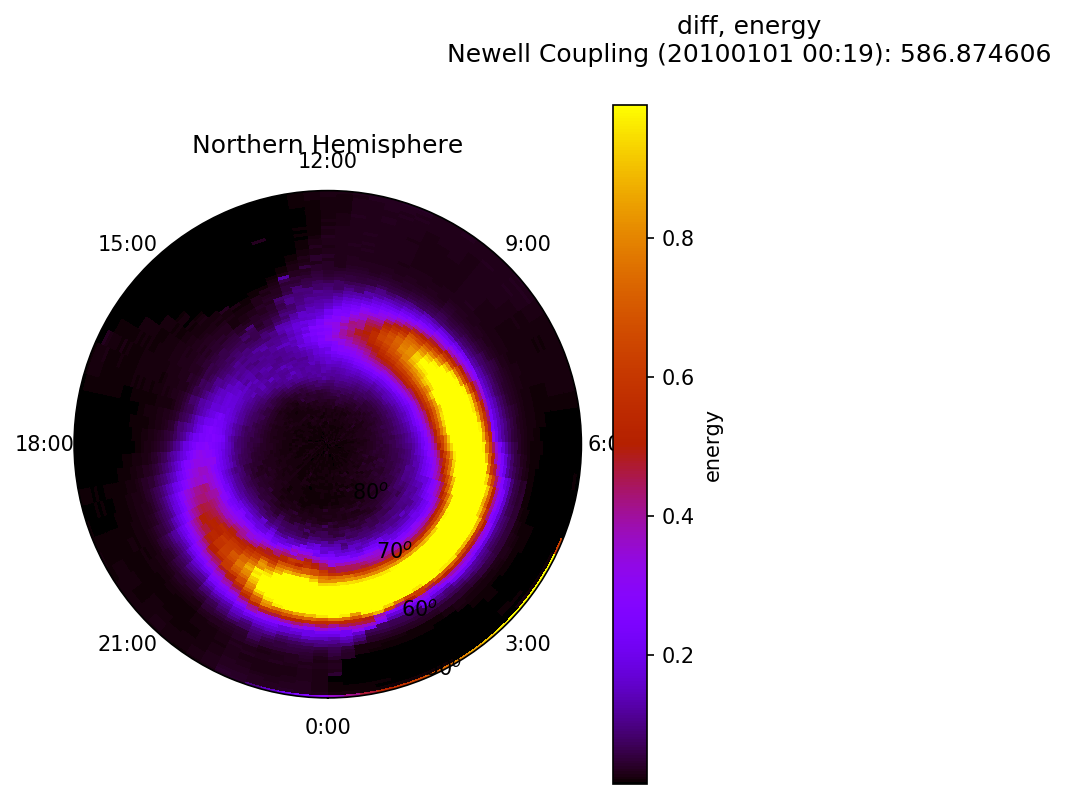

In [14]:



f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
pcolor_kwargs = {'cmap':'gnuplot'}

mappableN = pcolor_flux(axN,grid_mlats,grid_mlts,gridflux,'N',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label=jtype)
axN.set_title('Northern Hemisphere')
polar2dial(axN)
f.suptitle(('%s, %s' % (auroral_types[atype_index],jtype)
            +'\nNewell Coupling (%s): %f' % (dtstr,newell_coupling)))
plt.show()

- "model is paramaterized to use hourly solar wind data (only one unique result per hour)" i remember seeing 15 min somewhere...
- why is the scale 0 to ~0.5 for all energy types? How do i convert to actual value?
- why ovation using uniform grid, it has b1 and b2 values at each point? 
- 'saved' Coefficients for each grid point for each dF (newell value), should we be matching up each one or interpolating?
- why DMSP only having +lats?
- should i run the wedge interpolation? 
- should i use the bin correction?
- some values are zero
0.015066288420064699 2010-01-01 00:20:00 50.9473858883887 18.4583318208675 2 73

0.00809106675961269 2010-01-01 00:21:00 54.01312439198529 18.3778653682323 8 73

0.0 2010-01-01 00:23:00 60.177980904333495 18.167449948582803 20 72

0.0 2010-01-01 00:24:00 63.235318536828395 18.0285806853228 26 71

0.0 2010-01-01 00:25:00 66.24374767541721 17.857810276285 32 71

0.02985963018549797 2010-01-01 00:26:00 69.1769743507928 17.6435538672936 38 70

0.18843438256096706 2010-01-01 00:27:00 72.00529867785771 17.367745942089698 43 69


In [ ]:
# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
#print(numFeatures)

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

In [ ]:
print(X_val_scaled.shape)
X_test = np.zeros((X_val_scaled.shape[0],X_val_scaled.shape[0]+3),dtype=np.float32)
X = np.zeros((X_train_scaled.shape[0],X_train_scaled.shape[0]+3),dtype=np.float32)

X_test[:,:X_val_scaled.shape[0]] = X_val_scaled
X[:,:X_train_scaled.shape[0]] = X_train_scaled

X_test[:,X_val_scaled.shape[0]+3:] = ovation_fluxes
X[:,X_train_scaled.shape[0]+3:] = ovation_fluxes_train

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()model
#add model layers

model.add(Dense(int(32), activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), epochs=40)

In [ ]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

print(X_val_scaled, y_val_log.values, results)
plt.figure(figsize=(200,20))

plt.plot(y_val_log.values)
plt.plot(results)
plt.show()

In [ ]:
plt.figure(figsize=(50,15))

plt.plot(y_val_log.values[:1000])
plt.plot(results[:1000])
plt.show()

In [ ]:
kernel_size=